# GPM data combining and conversion

#### Combining the gpm highres nc4 datasets for each year and exporting to a singular classic netcdf dataset (individual for each year) to be used as input for nctoolkits cdo for regridding to lowres dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client, Variable
client = Client()
%matplotlib inline
%config IPCompleter.greedy = True

In [2]:
# from dask.diagnostics import ProgressBar

In [3]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('seaborn-pastel')
sns.set_theme(style="ticks")

In [4]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu_r', cmap_sequential='Blues')

In [4]:
# Getting the data

mfdataDIR1 = './data/GPM_data/gpm_2000/*.nc4'

ds1 = xr.open_mfdataset(mfdataDIR1, engine = 'netcdf4', combine = 'nested', concat_dim='time', parallel=True, chunks = {"time": 10}) # this is GPM IMERG data

In [5]:
ds1 = ds1.drop_dims(['lonv', 'latv', 'nv'])
ds1 = ds1.transpose('time', 'lat', 'lon')

In [6]:
ds1

<xarray.Dataset>
Dimensions:             (time: 10272, lon: 401, lat: 401)
Coordinates:
  * lat                 (lat) float32 -0.05 0.05 0.15 0.25 ... 39.75 39.85 39.95
  * lon                 (lon) float32 60.05 60.15 60.25 ... 99.85 99.95 100.1
  * time                (time) object 2000-06-01 00:00:00 ... 2000-12-31 23:3...
Data variables:
    precipitationCal    (time, lat, lon) float32 dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
    precipitationUncal  (time, lat, lon) float32 dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
    IRprecipitation     (time, lat, lon) float32 dask.array<chunksize=(1, 401, 401), meta=np.ndarray>
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2021-10-05 08:09:52 GMT Hyrax-1.16.3 htt...

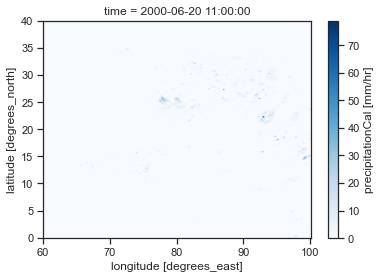

In [7]:
ds1.precipitationCal.sel(time = "2000-06-20 11:00:00").plot()

In [9]:
delayed_obj = ds1.to_netcdf('./data/GPM_ncdata/gpm_2000.nc', compute = False)

In [ ]:
with ProgressBar():
    results = delayed_obj.compute()

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "F:\aditya_sengupta\miniconda3\lib\site-packages\distributed\protocol\core.py", line 76, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "F:\aditya_sengupta\miniconda3\lib\site-packages\msgpack\__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 120, in msgpack._cmsgpack.Packer.__cinit__
MemoryError: Unable to allocate internal buffer.
distributed.comm.utils - ERROR - Unable to allocate internal buffer.
Traceback (most recent call last):
  File "F:\aditya_sengupta\miniconda3\lib\site-packages\distributed\comm\utils.py", line 33, in _to_frames
    return list(protocol.dumps(msg, **kwargs))
  File "F:\aditya_sengupta\miniconda3\lib\site-packages\distributed\protocol\core.py", line 76, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "F:\aditya_sen

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "F:\aditya_sengupta\miniconda3\lib\site-packages\distributed\protocol\core.py", line 76, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "F:\aditya_sengupta\miniconda3\lib\site-packages\msgpack\__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 292, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 298, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 295, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 285, in msgpack._cmsgpack.Packer._pack
  File "F:\aditya_sengupta\miniconda3\lib\site-packages\distributed\protocol\core.py", line 67, in _encode_default
    msgpack.dumps(
  File "F:\adit

In [11]:
ds1 = xr.open_dataset('./data/GPM_data/gpm_2001.nc')

In [10]:
ds1

<xarray.Dataset>
Dimensions:             (time: 10272, bnds: 2, lon: 401, lat: 401)
Coordinates:
  * time                (time) datetime64[ns] 2000-06-01 ... 2000-12-31T23:30:00
  * lon                 (lon) float32 60.05 60.15 60.25 ... 99.85 99.95 100.1
  * lat                 (lat) float32 -0.05 0.05 0.15 0.25 ... 39.75 39.85 39.95
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    lon_bnds            (lon, bnds) float32 ...
    lat_bnds            (lat, bnds) float32 ...
    precipitationCal    (time, lon, lat) float32 ...
    precipitationUncal  (time, lon, lat) float32 ...
    IRprecipitation     (time, lon, lat) float32 ...
Attributes:
    CDI:                             Climate Data Interface version 1.9.10 (h...
    Conventions:                     CF-1.6
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         Tue Oct 26 15:21:29 2021: cdo mergetime ...
    CDO:                             Climate Data Operators version 1.9.10 (h...

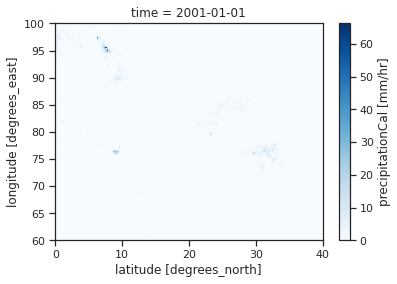

In [14]:
ds1.precipitationCal.isel(time = 0).plot()

In [8]:
ds2 = xr.open_dataset('./data/GPM_lowres_data/gpm_2000.nc4')

In [9]:
ds2

<xarray.Dataset>
Dimensions:             (time: 10272, bnds: 2, lon: 161, lat: 161)
Coordinates:
  * time                (time) datetime64[ns] 2000-06-01 ... 2000-12-31T23:30:00
  * lon                 (lon) float64 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * lat                 (lat) float64 0.0 0.25 0.5 0.75 ... 39.5 39.75 40.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    precipitationCal    (time, lon, lat) float32 ...
    precipitationUncal  (time, lon, lat) float32 ...
    IRprecipitation     (time, lon, lat) float32 ...
Attributes:
    CDI:                             Climate Data Interface version 1.9.10 (h...
    Conventions:                     CF-1.6
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         Tue Oct 26 15:59:18 2021: cdo -L -z zip_...
    CDO:                             Climate Data Operators version 1.9.10 (h...

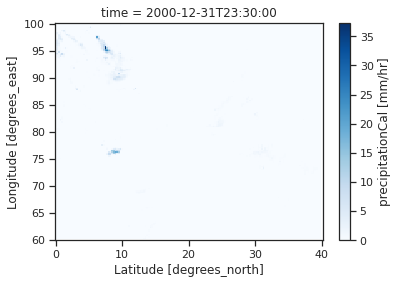

In [11]:
ds2.precipitationCal.isel(time = -1).plot()